# Installs & tokens

In [89]:
try:
    import mlflow
except ImportError:
    !pip install mlflow

In [90]:
try:
    import dotenv
except ImportError:
    !pip install python-dotenv

In [ ]:
# # Log into huggingface via Kaggle Secrets

# import os
# import huggingface_hub
# from kaggle_secrets import UserSecretsClient

# user_secrets = UserSecretsClient()
# HF_TOKEN = user_secrets.get_secret("HF_TOKEN")

# huggingface_hub.login(token=HF_TOKEN)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
# # Log into huggingface via .env

# import os
# from dotenv import load_dotenv
# import huggingface_hub

# load_dotenv()

# HF_TOKEN = os.getenv("HF_TOKEN")
# huggingface_hub.login(token=HF_TOKEN)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


# Choose notebook parameters

In [92]:
import torch

## CHOOSE MODEL PARAMETERS #################################################

HIDDEN_DIM = 3*768
DATA_PATH = 'data/'
DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
NAME_MODEL_NAME = 'cointegrated/rubert-tiny' # 'DeepPavlov/distilrubert-tiny-cased-conversational-v1'
DESCRIPTION_MODEL_NAME = 'cointegrated/rubert-tiny'

# BATCH_SIZE=90
# NUM_WORKERS=8
# NUM_DEBUG_SAMPLES=None
# EPOCHS=20

BATCH_SIZE=1
NUM_WORKERS=0
NUM_DEBUG_SAMPLES=2
EPOCHS=2

EMB_SIZE=768
VALIDATION_SPLIT=.25
SHUFFLE_DATASET=True
RANDOM_SEED=42
LR=9e-5
MOMENTUM=0.9
WEIGHT_DECAY=1e-2
CONTRASTIVE_MARGIN=1.5
CONTRASTIVE_THRESHOLD=0.3
SHEDULER_PATIENCE=3 # in epochs

MODEL_NAME_POSTFIX='splitting-by-query'

In [93]:
## CHOOSE DATA #########################################################

# # These table files need 'image_name_first', 'image_name_second' constructed from sku to be usable in current pipeline
# TABLE_DATASET_FILE = 'tables_labeled/processed/labeled_1.3k_with-options.csv'
# TABLE_DATASET_FILE = 'tables_labeled/processed/labeled_56k_with-options.csv'
# IMG_DATASET_NAME = 'images_7k'
# STRATIFY_COLS = None

# TABLE_DATASET_FILE = 'tables_labeled/processed/labeled_5k_with-options.csv'
# IMG_DATASET_NAME = 'images_7k' 
# STRATIFY_COLS = None

# TABLE_DATASET_FILE = 'tables_WB_OZ_100/WB_OZ_100.csv'
# TABLE_DATASET_FILE = 'tables_WB_OZ_100/WB_OZ_100_conjugated.csv'
# TABLE_DATASET_FILE = 'tables_WB_OZ_100/WB_OZ_100_conjugated_shuffled_seed=42_fraction=1.csv'
# TABLE_DATASET_FILE = 'tables_WB_OZ_100/WB_OZ_100_conjugated_shuffled_seed=42_fraction=0.5.csv'
# IMG_DATASET_NAME = 'images_WB_OZ_100'
# STRATIFY_COLS = None

TABLE_DATASET_FILE = 'tables_OZ_geo_5500/processed/regex-pairwise-dataset_num-queries=20_num-pairs=6226_patterns-dict-hash=6dbf9b3ef9568e60cd959f87be7e3b26.csv'
IMG_DATASET_NAME = 'images_OZ_geo_5500'
STRATIFY_COLS = ['sku_first', 'label']

In [ ]:
## LOGGING PARAMS ######################################################################

# MLFLOW_URI = "http://176.56.185.96:5000"
# MLFLOW_URI = "http://localhost:5000"
MLFLOW_URI = None

MLFLOW_EXPERIMENT = "siamese/1fold"

TELEGRAM_TOKEN = None
# TELEGRAM_TOKEN = '' # set token to get notifications

# Definitions

In [95]:
# Imports
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import mlflow
from mlflow.models import infer_signature

from timm import create_model
import numpy as np
import pandas as pd
import os
import torch
from torch import nn
from torch import optim, Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from torchinfo import summary
# import transformers
# from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer,\
#         get_linear_schedule_with_warmup
from transformers import AutoModel, AutoTokenizer

import cv2

from PIL import Image
from tqdm.auto import tqdm

# import json
# from itertools import product

# import datasets
# from datasets import Dataset, concatenate_datasets
# import argparse
import requests

# from io import BytesIO
# from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
from IPython import display
# import more_itertools

from sklearn.model_selection import train_test_split

In [96]:
def make_tg_report(text, token=None) -> None:
    method = 'sendMessage'
    chat_id = 324956476
    _ = requests.post(
            url='https://api.telegram.org/bot{0}/{1}'.format(token, method),
            data={'chat_id': chat_id, 'text': text} 
        ).json()

In [97]:
class RuCLIPtiny(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = create_model('convnext_tiny',
                                   pretrained=False, # TODO: берём претрейн
                                   num_classes=0,
                                   in_chans=3)  # out 768

        self.transformer = AutoModel.from_pretrained(NAME_MODEL_NAME)
        name_model_output_shape = self.transformer.config.hidden_size  # dynamically get hidden size
        self.final_ln = torch.nn.Linear(name_model_output_shape, 768)  # now uses the transformer hidden size
        self.logit_scale = torch.nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

    @property
    def dtype(self):
        return self.visual.stem[0].weight.dtype

    def encode_image(self, image):
        return self.visual(image.type(self.dtype))

    def encode_text(self, input_ids, attention_mask):
        x = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        x = x.last_hidden_state[:, 0, :]
        x = self.final_ln(x)
        return x

    def forward(self, image, input_ids, attention_mask):
        image_features = self.encode_image(image)
        text_features = self.encode_text(input_ids, attention_mask)

        # normalized features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        return logits_per_image, logits_per_text
    
def get_transform():
    return transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        _convert_image_to_rgb,
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]), ])

def _convert_image_to_rgb(image):
    return image.convert("RGB")

class Tokenizers:
    def __init__(self):
        self.name_tokenizer = AutoTokenizer.from_pretrained(NAME_MODEL_NAME)
        self.desc_tokenizer = AutoTokenizer.from_pretrained(DESCRIPTION_MODEL_NAME)

    def tokenize_name(self, texts, max_len=77):
        tokenized = self.name_tokenizer.batch_encode_plus(texts,
                                                     truncation=True,
                                                     add_special_tokens=True,
                                                     max_length=max_len,
                                                     padding='max_length',
                                                     return_attention_mask=True,
                                                     return_tensors='pt')
        return torch.stack([tokenized["input_ids"], tokenized["attention_mask"]])
    
    def tokenize_description(self, texts, max_len=77):
        tokenized = self.desc_tokenizer(texts,
                                        truncation=True,
                                        add_special_tokens=True,
                                        max_length=max_len,
                                        padding='max_length',
                                        return_attention_mask=True,
                                        return_tensors='pt')
        return torch.stack([tokenized["input_ids"], tokenized["attention_mask"]])

In [98]:
class SiameseRuCLIPDataset(torch.utils.data.Dataset):
    def __init__(self, df=None, labels=None, df_path=None, images_dir=DATA_PATH+'images/'):
        # loads data either from path using `df_path` or directly from `df` argument
        self.df = pd.read_csv(df_path) if df_path is not None else df
        self.labels = labels
        self.images_dir = images_dir
        self.tokenizers = Tokenizers()
        self.transform = get_transform()
        # 
        self.max_len = 77
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        name_tokens = self.tokenizers.tokenize_name([str(row.name_first), 
                                               str(row.name_second)], max_len=self.max_len)
        name_first = name_tokens[:, 0, :] # [input_ids, attention_mask]
        name_second = name_tokens[:, 1, :]
        desc_tokens = self.tokenizers.tokenize_description([str(row.description_first), 
                                               str(row.description_second)])
        desc_first = desc_tokens[:, 0, :] # [input_ids, attention_mask]
        desc_second = desc_tokens[:, 1, :]
        im_first = cv2.imread(os.path.join(self.images_dir, row.image_name_first))
        im_first = cv2.cvtColor(im_first, cv2.COLOR_BGR2RGB)
        im_first = Image.fromarray(im_first)
        im_first = self.transform(im_first)
        im_second = cv2.imread(os.path.join(self.images_dir, row.image_name_second))
        im_second = cv2.cvtColor(im_second, cv2.COLOR_BGR2RGB)
        im_second = Image.fromarray(im_second)
        im_second = self.transform(im_second)
        label = self.labels[idx]
        return im_first, name_first, desc_first, im_second, name_second, desc_second, label

    def __len__(self,):
        return len(self.df)
    
def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
        last_hidden = last_hidden_states.masked_fill(
            ~attention_mask[..., None].bool(), 0.0
        )
        return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

class SiameseRuCLIP(nn.Module):
    def __init__(self, preload_ruclip=True, device='cpu', hidden_dim=HIDDEN_DIM, models_dir=DATA_PATH + 'train_results/'):
        super().__init__()
        self.ruclip = RuCLIPtiny()
        if preload_ruclip:
            preload_model_name = 'cc12m_rubert_tiny_ep_1.pt' #'cc12m_ddp_4mill_ep_4.pt'
            std = torch.load(models_dir + preload_model_name, weights_only=True, map_location=device)
            self.ruclip.load_state_dict(std)
            self.ruclip = self.ruclip.to(device)
            self.ruclip.eval()
        self.description_transformer = AutoModel.from_pretrained(DESCRIPTION_MODEL_NAME)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            # # nn.BatchNorm1d(hidden_dim),
            # nn.Dropout(0.3), 
            # nn.Linear(hidden_dim, hidden_dim // 2),
            # nn.ReLU(), 
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
        )
        
    def encode_description(self, desc):
        # desc is [input_ids, attention_mask]
        last_hidden_states = self.description_transformer(desc[:, 0, :], desc[:, 1, :]).last_hidden_state
        attention_mask = desc[:, 1, :]
        # TODO: нужно ли делать пулинг, посмотреть на результаты
        return average_pool(last_hidden_states, attention_mask)
    
    def forward(self, im1, name1, desc1, im2, name2, desc2):
        image_emb1 = self.ruclip.encode_image(im1)
        image_emb2 = self.ruclip.encode_image(im2)
        name_emb1 = self.ruclip.encode_text(name1[:, 0, :], name1[:, 1, :])
        name_emb2 = self.ruclip.encode_text(name2[:, 0, :], name2[:, 1, :])
        desc_emb1 = self.ruclip.encode_text(desc1[:, 0, :], desc1[:, 1, :])
        desc_emb2 = self.ruclip.encode_text(desc2[:, 0, :], desc2[:, 1, :])
        # desc_emb1 = self.encode_description(desc1) 
        # desc_emb2 = self.encode_description(desc2)
        first_emb = torch.cat([image_emb1, name_emb1, desc_emb1], dim=1)
        second_emb = torch.cat([image_emb2, name_emb2, desc_emb2], dim=1)
        out1 = self.head(first_emb)
        out2 = self.head(second_emb)
        return out1, out2
    

In [99]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def __name__(self,):
        return 'ContrastiveLoss'

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        pos = (1-label) * torch.pow(euclidean_distance, 2)
        neg = label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        loss_contrastive = torch.mean( pos + neg )
        return loss_contrastive

In [100]:
def evaluate_pair(output1, output2, target, threshold):
    euclidean_distance = F.pairwise_distance(output1, output2)
    # меньше границы, там где будет True — конкуренты
    cond = euclidean_distance < threshold
    pos_sum = 0
    neg_sum = 0
    pos_acc = 0
    neg_acc = 0

    for i in range(len(cond)):
        # 1 значит не конкуренты
        if target[i]:
            neg_sum+=1
            # 0 в cond значит дальше друг от друга чем threshold
            if not cond[i]:
                neg_acc+=1
        elif not target[i]:
            pos_sum+=1
            if cond[i]:
                pos_acc+=1

    return pos_acc, pos_sum, neg_acc, neg_sum

def predict(out1, out2, threshold=CONTRASTIVE_THRESHOLD):
    # вернёт 1 если похожи
    return F.pairwise_distance(out1, out2) < threshold

In [101]:
def validation(model, criterion, valid_loader, epoch, device='cpu', split_name='validation') -> float:
    assert split_name in ['train', 'validation', 'test']

    valid_loss = 0
    val_pos_accuracy = 0
    val_neg_accuracy = 0
    num_pos = 0
    num_neg = 0

    with torch.no_grad(): 
        for data in tqdm(valid_loader, desc=split_name):
            im1, name1, desc1, im2, name2, desc2, label = data 
            im1, name1, desc1, im2, name2, desc2, label = (
                im1.to(device), name1.to(device), desc1.to(device),
                im2.to(device), name2.to(device), desc2.to(device), label.to(device)
            )
            out1, out2 = model(im1, name1, desc1, im2, name2, desc2) 
            loss = criterion(out1, out2, label)
            pos_acc, pos_sum, neg_acc, neg_sum = evaluate_pair(out1, out2, label, CONTRASTIVE_THRESHOLD)
            val_pos_accuracy += pos_acc
            val_neg_accuracy += neg_acc
            num_pos += pos_sum
            num_neg += neg_sum
            valid_loss += loss.item()

    val_pos_accuracy = val_pos_accuracy / num_pos if num_pos > 0 else 0.0
    val_neg_accuracy = val_neg_accuracy / num_neg if num_neg > 0 else 0.0
    valid_loss = valid_loss / len(valid_loader) if len(valid_loader) > 0 else 0.0

    report = (
        f"[{split_name}] Epoch: {epoch}, loss: {valid_loss:.3f}, "
        f"P Acc: {val_pos_accuracy:.3f}, N Acc: {val_neg_accuracy:.3f} " + MODEL_NAME_POSTFIX + '\n'
    )
    print(report)
    make_tg_report(report, TELEGRAM_TOKEN)
    
    return val_pos_accuracy, val_neg_accuracy, (val_pos_accuracy + val_neg_accuracy) / 2

In [102]:
from pathlib import Path

def plot_epoch(loss_history, filename="data/runs_artifacts/epoch_loss.png") -> None:
    Path(filename).parent.mkdir(parents=True, exist_ok=True)
    display.clear_output(wait=True)
    plt.figure(figsize=(6, 4))
    plt.title("Training loss")
    plt.xlabel("Iteration number")
    plt.ylabel("Loss")
    plt.plot(loss_history, 'b')
    plt.tight_layout()
    plt.savefig(filename)  # Save the plot to a file
    plt.show()

In [103]:
def train(model, optimizer, criterion, 
          epochs_num, train_loader, valid_loader=None, 
          device='cpu', print_epoch=False) -> None:

    model.train()
    model.to(device)
    counter = []
    loss_history = [] 
    it_number = 0
    best_valid_score = 0
    best_weights = None
    scheduler = ReduceLROnPlateau(optimizer, mode="max",
                                            factor=0.1, patience=SHEDULER_PATIENCE,
                                            threshold=0.0001,
                                            threshold_mode='rel', cooldown=0,
                                            min_lr=0, eps=1e-08)

    for epoch in range(epochs_num):
        print("Epoch：", epoch)
        for i, data in enumerate(tqdm(train_loader, desc='train')):
            im1, name1, desc1, im2, name2, desc2, label = data 
            im1, name1, desc1, im2, name2, desc2, label = im1.to(device), name1.to(device), desc1.to(device), im2.to(device), name2.to(device), desc2.to(device), label.to(device)
            optimizer.zero_grad() 
            out1, out2 = model(im1, name1, desc1, im2, name2, desc2)
            loss = criterion(out1, out2, label)
            if MLFLOW_URI:
                mlflow.log_metric("train_loss", f"{loss:2f}", step=epoch)
            loss.backward()
            optimizer.step()
            if i % 1 == 0: # show changes of loss value after each 10 batches
                # it_number += 5
                counter.append(it_number)
                loss_history.append(loss.item())

        # validate after each epoch
        if print_epoch:
            val_pos_acc, val_neg_acc, val_acc = validation(
                model, criterion, valid_loader, epoch, device, split_name='validation'
            )

            if MLFLOW_URI:
                mlflow.log_metric("valid_pos_accuracy", f"{val_pos_acc:2f}", step=epoch)
                mlflow.log_metric("valid_neg_accuracy", f"{val_neg_acc:2f}", step=epoch)
                mlflow.log_metric("valid_accuracy", f"{val_acc:2f}", step=epoch)

            plot_epoch(loss_history)
            print(f'Current train loss: {loss}')
            # print(f'Current {score.__name__}: {valid_score}')
            lr_to_log = optimizer.param_groups[0]['lr']
            if MLFLOW_URI:
                mlflow.log_metric("lr", f"{lr_to_log:2f}", step=epoch)
            scheduler.step(val_acc)
            if val_acc > best_valid_score:
                best_valid_score = val_acc
                best_weights = model.state_dict()
    return best_valid_score, best_weights

# Prepare data

## Download data from HF

In [104]:
TABLE_DATASET_FILE

'tables_OZ_geo_5500/processed/regex-pairwise-dataset_num-queries=20_num-pairs=6226_patterns-dict-hash=6dbf9b3ef9568e60cd959f87be7e3b26.csv'

In [ ]:
# Download models' weights & text/image datasets

from huggingface_hub import snapshot_download
from pathlib import Path

REPO_ID = "INDEEPA/clip-siamese"
LOCAL_DIR = Path("data/train_results")
LOCAL_DIR.mkdir(parents=True, exist_ok=True)

snapshot_download(
    repo_id=REPO_ID,
    repo_type='dataset',
    local_dir='data',
    allow_patterns=[
        "train_results/cc12m*.pt",
        TABLE_DATASET_FILE,
        f"{IMG_DATASET_NAME}.zip"
    ],
)

!unzip -n -q data/{IMG_DATASET_NAME}.zip -d data/

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

siamese_contrastive_1gpu.pt:   0%|          | 0.00/220M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Split data by query sku

In [ ]:
TABLE_DATASET_PATH = DATA_PATH + TABLE_DATASET_FILE

labeled = pd.read_csv(TABLE_DATASET_PATH)
print(f"Unique query sku: {labeled.sku_query.nunique()}")

Unique query sku: 20


In [60]:
# split into train/val/test

import numpy as np
import pandas as pd
from typing import Tuple

def split_pairwise(
    df: pd.DataFrame,
    test_size: float = 0.20,
    random_state: int | None = None,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Leakage-free DEV / TEST split for a pair-wise SKU dataset.
    Input `df` must have columns ['sku_query','sku_candidate','label'].
    """
    rng = np.random.default_rng(random_state)
    test_rows, dev_rows   = [], []
    test_entities: set[str] = set()

    # ---- iterate over each original query SKU ------------------------------
    for q_sku, grp in df.groupby("sku_query"):
        pos_idx = grp.index[grp.label == 1].tolist()
        neg_idx = grp.index[grp.label == 0].tolist()

        # --- (1) sample TEST rows -------------------------------------------
        n_pos = int(np.ceil(test_size * len(pos_idx))) if pos_idx else 0
        n_neg = int(np.ceil(test_size * len(neg_idx))) if neg_idx else 0

        pos_test = rng.choice(pos_idx, size=n_pos, replace=False) if n_pos else []
        neg_test = rng.choice(neg_idx, size=n_neg, replace=False) if n_neg else []

        test_rows.extend(pos_test)
        test_rows.extend(neg_test)

        # register every entity that just entered TEST
        test_entities.add(q_sku)
        test_entities.update(df.loc[pos_test, "sku_candidate"])
        test_entities.update(df.loc[neg_test, "sku_candidate"])

        # --- (2) build DEV from remaining rows ------------------------------
        remain_pos = list(set(pos_idx) - set(pos_test))
        remain_neg = list(set(neg_idx) - set(neg_test))

        if remain_pos:
            # choose substitute query (one of the remaining positives)
            sub_idx  = int(rng.choice(remain_pos))
            sub_sku  = df.loc[sub_idx, "sku_candidate"]

            for idx in remain_pos:
                if idx == sub_idx:            # skip (sub,sub) self-pair
                    continue
                row = df.loc[idx].copy()
                row["sku_query"] = sub_sku
                dev_rows.append(row)

            for idx in remain_neg:
                row = df.loc[idx].copy()
                row["sku_query"] = sub_sku
                dev_rows.append(row)

    # ---- materialise the splits -------------------------------------------
    test_df = df.loc[test_rows].reset_index(drop=True)
    dev_df  = pd.DataFrame(dev_rows).reset_index(drop=True)

    # ---- (3) final purge: remove any row touching a TEST entity ------------
    mask = ~(dev_df["sku_query"].isin(test_entities) |
             dev_df["sku_candidate"].isin(test_entities))
    dev_df = dev_df[mask].reset_index(drop=True)

    return dev_df, test_df

In [61]:
# split into train/val/test

dev_df,  test_df  = split_pairwise(labeled,  test_size=0.05, random_state=42)
train_df, val_df  = split_pairwise(dev_df,   test_size=0.1, random_state=42)

train_df.shape, val_df.shape, test_df.shape

((2548, 95), (409, 95), (332, 95))

In [62]:
# Print positive/negative pairs count per each split 

import pandas as pd

# collect your splits in a dict
splits = {
    'train': train_df,
    'val':   val_df,
    'test':  test_df,
}

# build the summary_df records
records = []
for name, df in splits.items():
    vc = df['label'].value_counts()
    records.append({
        'split':    name,
        'negative': vc.get(0, 0),
        'positive': vc.get(1, 0),
        'total':    len(df),
    })

# create a DataFrame and set the split name as index
summary_df = (
    pd.DataFrame(records)
      .set_index('split')
      .astype(int)
)

print(summary_df)

       negative  positive  total
split                           
train      2210       338   2548
val         348        61    409
test        280        52    332


In [63]:
import pandas as pd
from collections import Counter

def sanity_checks(train: pd.DataFrame, val: pd.DataFrame, test: pd.DataFrame):
    """
    Verify that:
      1) Each query SKU appears in exactly one split
      2) No SKU (query or candidate) overlaps across splits
      3) No duplicate pairs across splits
      4) Each split has at least one positive and one negative
    """
    # 1) Query-level disjointness
    q_train = set(train["sku_query"])
    q_val   = set(val  ["sku_query"])
    q_test  = set(test ["sku_query"])
    assert not (q_train & q_val),   f"Query SKU overlap train↔val: {q_train & q_val}"
    assert not (q_train & q_test),  f"Query SKU overlap train↔test: {q_train & q_test}"
    assert not (q_val   & q_test),  f"Query SKU overlap val↔test:   {q_val   & q_test}"
    
    # 2) Global SKU disjointness (query OR candidate)
    def all_skus(df):
        return set(df["sku_query"]) | set(df["sku_candidate"])
    s_train, s_val, s_test = all_skus(train), all_skus(val), all_skus(test)
    assert not (s_train & s_val),   f"SKU overlap train↔val: {s_train & s_val}"
    assert not (s_train & s_test),  f"SKU overlap train↔test: {s_train & s_test}"
    assert not (s_val   & s_test),  f"SKU overlap val↔test:   {s_val   & s_test}"
    
    # 3) Unique pairs
    all_pairs = pd.concat([train, val, test], ignore_index=True)
    dupes = all_pairs.duplicated(subset=["sku_query","sku_candidate","label"])
    assert not dupes.any(), f"Found {dupes.sum()} duplicate pairs across splits"
    
    # 4) Label coverage in each split
    for name, df in [("train", train), ("val", val), ("test", test)]:
        labels = df["label"].unique()
        assert set(labels) == {0,1}, f"{name} split has labels {labels}, expected {{0,1}}"
    
    print("✅ All sanity checks passed!")

sanity_checks(train_df, val_df, test_df)

✅ All sanity checks passed!


In [64]:
def sample_split(df: pd.DataFrame, num_samples: int | None, random_state: int) -> pd.DataFrame:
    """
    If num_samples is set, take up to that many random rows;
    otherwise just shuffle the entire DataFrame.
    Always resets the index.
    """
    if num_samples is not None:
        n = min(num_samples, len(df))
        out = df.sample(n=n, random_state=random_state)
    else:
        out = df.sample(frac=1, random_state=random_state)
    return out.reset_index(drop=True)

# apply to each split
train_df = sample_split(train_df, NUM_DEBUG_SAMPLES, RANDOM_SEED)
val_df   = sample_split(val_df,   NUM_DEBUG_SAMPLES, RANDOM_SEED)
test_df  = sample_split(test_df,  NUM_DEBUG_SAMPLES, RANDOM_SEED)

# Run training

In [65]:
from torch.utils.data import DataLoader

def _run():
    images_dir = os.path.join(DATA_PATH, IMG_DATASET_NAME)

    # 1) Prepare splits and rename columns
    splits = {
        'train':      train_df,
        'validation': val_df,
        'test':       test_df,
    }
    loaders = {}

    for split_name, df in splits.items():
        # rename for dataset compatibility
        df = df.rename(columns={
            col: col.replace("_query", "_first").replace("_candidate", "_second")
            for col in df.columns
            if "_query" in col or "_candidate" in col
        })

        # build dataset + loader
        labels = df["label"].values
        ds     = SiameseRuCLIPDataset(df.drop(columns="label"), labels, images_dir=images_dir)

        shuffle = (split_name == 'train')
        loaders[split_name] = DataLoader(
            ds,
            batch_size=BATCH_SIZE,
            shuffle=shuffle,
            num_workers=NUM_WORKERS
        )

    train_loader = loaders['train']
    valid_loader = loaders['validation']
    test_loader  = loaders['test']

    # 2) Model, loss, optimizer
    print('Loading model...')
    model     = SiameseRuCLIP(device=DEVICE).to(DEVICE)
    criterion = ContrastiveLoss(margin=CONTRASTIVE_MARGIN).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    print('Done loading model.')

    # 3) (Optional) MLflow setup
    if MLFLOW_URI:
        mlflow.set_tracking_uri(MLFLOW_URI)
        mlflow.set_experiment(MLFLOW_EXPERIMENT)
        mlflow.enable_system_metrics_logging()
        mlflow.start_run()
        mlflow.log_params({
            "epochs":       EPOCHS,
            "lr":           LR,
            "batch_size":   BATCH_SIZE,
            "weight_decay": WEIGHT_DECAY,
            "num_workers":  NUM_WORKERS,
        })

    # 4) Training + validation
    _, best_weights = train(
        model, optimizer, criterion,
        EPOCHS, train_loader, valid_loader,
        print_epoch=True,
        device=DEVICE
    )

    # 5) FINAL TESTING
    test_pos_acc, test_neg_acc, test_acc = validation(
        model,
        criterion,
        test_loader,
        epoch=EPOCHS,
        device=DEVICE,
        split_name='test'
    )

    # 6) Save best weights
    print('Saving model...')
    torch.save(best_weights, DATA_PATH + f"train_results/siamese_contrastive_{MODEL_NAME_POSTFIX}.pt")

    # 7) Log model signature (no example) if using MLflow
    if MLFLOW_URI:
        # infer signature from a small batch
        batch = next(iter(valid_loader))
        # move to CPU/NumPy and back to torch to compute output shapes
        inputs = [t.to(DEVICE).cpu().numpy() for t in batch[:-1]]
        tensors = [torch.from_numpy(arr).to(DEVICE) for arr in inputs]
        outputs = model(*tensors)
        outputs = [o.cpu().detach().numpy() for o in outputs]

        signature = infer_signature(
            {k: v for k, v in zip(
                ["im1","name1","desc1","im2","name2","desc2"], inputs
            )},
            {"out1": outputs[0], "out2": outputs[1]}
        )

        mlflow.pytorch.log_model(
            model,
            artifact_path="model",
            signature=signature
        )
    print('Done saving model.')

    if MLFLOW_URI:
        mlflow.log_metric("test_pos_accuracy", f"{test_pos_acc:2f}")
        mlflow.log_metric("test_neg_accuracy", f"{test_neg_acc:2f}")
        mlflow.log_metric("test_accuracy", f"{test_acc:2f}")
        mlflow.end_run()

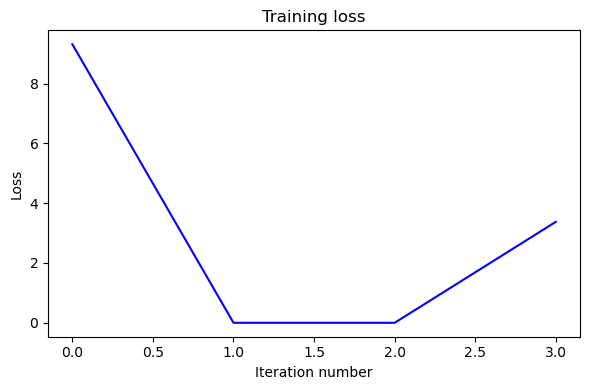

Current train loss: 3.376269578933716


test:   0%|          | 0/2 [00:00<?, ?it/s]

[test] Epoch: 2, loss: 3.878, P Acc: 0.000, N Acc: 0.000 splitting-by-query

Saving model...


2025/05/21 16:32:35 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/05/21 16:32:35 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Done saving model.
🏃 View run beautiful-seal-509 at: http://localhost:5000/#/experiments/103866307993097995/runs/cbed3e205f364fa1a87ac71a17851ae3
🧪 View experiment at: http://localhost:5000/#/experiments/103866307993097995


In [66]:
_run()